# So let's do stock market index prediction

Stuff I try:

* Simple Linear Regression with various time windows (works best)
* SpaceTime: a cool new thing I try out but turns out is beat by simple linear regression

ideas

augment data with nse data

## References

Spacetime:
* [Paper](https://openreview.net/forum?id=2EpjkjzdCAa)
* [Code](https://colab.research.google.com/drive/1dyR7ZGnjNfS2GMjRUfDzujQLhxSo-Xsk?usp=sharing#scrollTo=q31JDyqQCgV_)


In [7]:
!pip install yfinance

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/stock-index/sample_close.txt
/kaggle/input/stock-index/sample_input.csv
/kaggle/input/stock-index/0f411c708e55af442eafb33bfb7ee7585f5b0211a52d9ccc4287a23d8d6abe76_STOCK_INDEX.csv


In [8]:
import yfinance as yf
nse_ticker = "^NSEI"
nse_data = yf.download(nse_ticker, start="2013-01-21", end="2023-06-30")
print(nse_data)

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2013-01-21   6085.750000   6094.350098   6065.100098   6082.299805   
2013-01-22   6080.149902   6101.299805   6040.500000   6048.500000   
2013-01-23   6052.850098   6069.799805   6021.149902   6054.299805   
2013-01-24   6046.200195   6065.299805   6007.850098   6019.350098   
2013-01-25   6024.500000   6080.549805   6014.450195   6074.649902   
...                  ...           ...           ...           ...   
2023-06-22  18853.599609  18886.599609  18759.500000  18771.250000   
2023-06-23  18741.849609  18756.400391  18647.099609  18665.500000   
2023-06-26  18682.349609  18722.050781  18646.699219  18691.199219   
2023-06-27  18748.550781  18829.250000  18714.250000  18817.400391   
2023-06-28  18908.150391  19011.250000  18861.349609  18972.099609   

               Adj C

In [10]:
df = nse_data.reset_index()

In [11]:
bse_ticker = "^BSESN"

# Fetch BSE data
bse_data = yf.download(bse_ticker, start="2004-01-01", end="2023-06-30")

# Print the fetched data
print(bse_data)


[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2004-01-02   5944.229980   6034.379883   5944.229980   6026.589844   
2004-01-05   6050.479980   6078.109863   5964.649902   6039.000000   
2004-01-06   6068.680176   6121.200195   5916.330078   5943.640137   
2004-01-07   5970.350098   5985.299805   5870.549805   5957.020020   
2004-01-08   5992.100098   6118.620117   5992.100098   6108.540039   
...                  ...           ...           ...           ...   
2023-06-22  63601.710938  63601.710938  63200.628906  63238.890625   
2023-06-23  63124.281250  63240.628906  62874.121094  62979.371094   
2023-06-26  62946.500000  63136.089844  62853.671875  62970.000000   
2023-06-27  63151.851562  63467.539062  63054.839844  63416.031250   
2023-06-28  63701.781250  64050.441406  63554.820312  63915.421875   

               Adj C

In [12]:
# check for NA values
nse_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# SpaceTime

Most of the code is taken verbatim, with modifications to run on Kaggle

In [13]:
# Clone their github repo
!git clone https://github.com/HazyResearch/spacetime.git

fatal: destination path 'spacetime' already exists and is not an empty directory.


In [14]:
import os
import sys
from os.path import join
project_dir = './spacetime'
sys.path.insert(0, os.path.abspath(project_dir)) 
import yaml

with open(join(project_dir, 'environment.yaml')) as file_handle:
    environment_data = yaml.safe_load(file_handle)

requirements = []
for dep in environment_data['dependencies']:
    if isinstance(dep, str):
        try:
            package, package_version = dep.split('=')
            package_version = f'=={package_version}'
        except:
            package = dep
            package_version = ''
        if package not in ['python', 'pip', 'jupyter', 'jupyterlab',
                           'pytorch', 'pandas', 'numpy', 'matplotlib']:
            requirements.append(f'{package}{package_version}')
    elif isinstance(dep, dict):
        for preq in dep.get('pip', []):
            requirements.append(preq)

with open('requirements.txt', 'w') as fp:
    for requirement in requirements:
       print(requirement, file=fp)

In [15]:
!pip install -r requirements.txt

In [19]:
import importlib
folder_path = '/kaggle/working/spacetime/'
utils = importlib.import_module('utils', folder_path)
train = importlib.import_module('train', folder_path)

# epoch_module = importlib.import_module('epoch_module', '/kaggle/working/spacetime/train/epoch.py')
# sys.modules['.epoch'] = epoch_module

In [20]:
import utils.logging

In [21]:
from omegaconf import OmegaConf

In [22]:
args = """
seed: 42
"""
args = OmegaConf.create(args)

In [23]:
args.lag = 50       # We'll use the prior 12 calendar weeks as inputs
args.horizon = 2     # We'll then try to predict out the next 20 available days (4ish working weeks)
args.target = 'Close'  # Pick one feature to forecast 

# Windows of samples
samples = [w.to_numpy() for w in df[args.target].rolling(window=args.lag + args.horizon)][args.lag + args.horizon - 1:]
# Dates for each sample
dates = [w for w in df['Date'].rolling(window=args.lag + args.horizon)][args.lag + args.horizon - 1:]

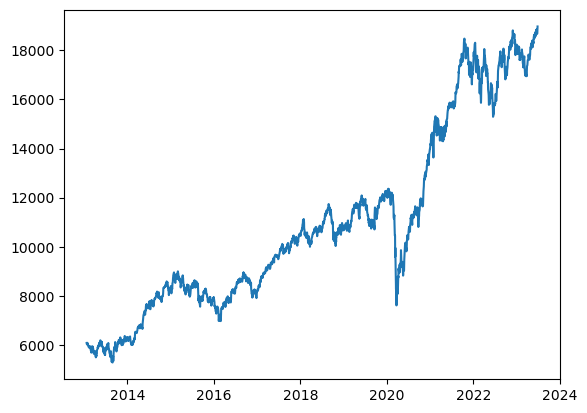

In [24]:
plt.plot(df['Date'], df['Close'])
plt.show()

In [25]:
import datetime

test_year = 2023
test_date = datetime.date(test_year, 1, min(args.horizon, 30)) 

## Convert 'Date' to datetime object
df['Date'] = pd.to_datetime(df['Date']).dt.date

## Find indices corresponding to test year dates
test_ix = len(dates) - df[df['Date'] >= test_date].shape[0]

In [26]:
dates[test_ix][args.lag:args.lag + args.horizon]

2441   2022-12-30
2442   2023-01-02
Name: Date, dtype: datetime64[ns]

In [27]:
def train_val_split(data_indices, val_ratio=0.1):
    train_ratio = 1 - val_ratio
    last_train_index = int(np.round(len(data_indices) * train_ratio))
    return data_indices[:last_train_index], data_indices[last_train_index:]

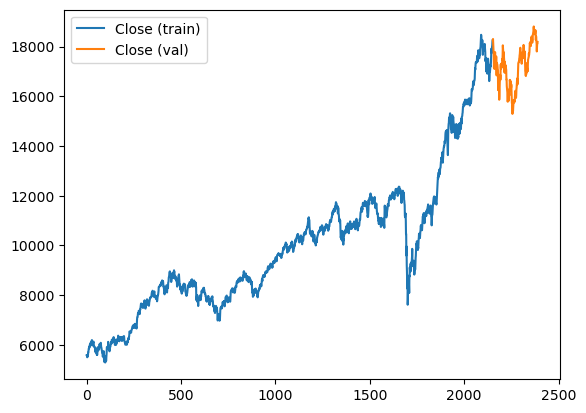

In [28]:
# Split data indices for train and val sets
train_indices, val_indices = train_val_split(np.arange(test_ix))
train_samples = np.array(samples[:val_indices[0]])
val_samples = np.array(samples[val_indices[0]:val_indices[-1]])

# Sanity check the splits by plotting the last horizon term in each sample
ix = -1
plt.plot(train_samples[:, ix], label=f'{args.target} (train)', alpha=1)
plt.plot(np.arange(len(train_samples), len(train_samples) + len(val_samples)), 
         val_samples[:, ix], label=f'{args.target} (val)', alpha=1)
plt.legend()
plt.show()

In [29]:
import copy
import torch
from torch.utils.data import Dataset, DataLoader

In [30]:
class YahooStockPriceDataset(Dataset):
    def __init__(self, data: np.array, lag: int, horizon: int):
        super().__init__()
        self.data_x = torch.tensor(data).unsqueeze(-1).float()
        self.data_y = copy.deepcopy(self.data_x[:, -horizon:, :])
        
        self.lag = lag
        self.horizon = horizon
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        x[-self.horizon:] = 0  # Mask input horizon terms
        return x, y, (self.lag, self.horizon)
    
    # For simplicity, we just keep these as identities.
    # But we could imagine some kind of data transformation / scaling for the inputs
    def transform(self, x):
        return x
    
    def inverse_transform(self, x):
        return x
        

In [31]:
# Function to load dataloaders for train, val, and test splits
def load_data(df: pd.DataFrame, 
              lag: int, 
              horizon: int, 
              target: str, 
              val_ratio: float,
              test_year_month_day: list[int], 
              **dataloader_kwargs: any):
    
    # Convert day-wise data into sequences of lag + horizon terms
    samples = [w.to_numpy() for w in df[target].rolling(window=lag + horizon)][lag + horizon - 1:]
    dates   = [w for w in df['Date'].rolling(window=lag + horizon)][lag + horizon - 1:]
    
    # Set aside test samples by date
    test_date = datetime.date(*test_year_month_day)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    test_ix = len(dates) - df[df['Date'] >= test_date].shape[0]
    test_samples = np.array(samples[test_ix:])
    
    # Get training + validation samples
    train_indices, val_indices = train_val_split(np.arange(len(dates[:test_ix])), val_ratio)
    train_samples = np.array(samples[:val_indices[0]])
    val_samples = np.array(samples[val_indices[0]:val_indices[-1]])
    
    # PyTorch datasets and dataloaders
    datasets = [YahooStockPriceDataset(_samples, lag, horizon)
                for _samples in [train_samples, val_samples, test_samples]]
    
    dataloaders = [DataLoader(dataset, shuffle=True if ix == 0 else False, **dataloader_kwargs)
                   for ix, dataset in enumerate(datasets)]
    return dataloaders

In [32]:
# Function to visualize samples over time
def visualize_data(dataloaders, sample_idx, sample_dim=0,
                   splits=['train', 'val', 'test'], title=None):
    assert len(splits) == len(dataloaders)
    start_idx = 0
    for idx, split in enumerate(splits):
        y = dataloaders[idx].dataset.data_x[:, sample_idx, sample_dim]
        x = np.arange(len(y)) + start_idx
        plt.plot(x, y, label=split)
        start_idx += len(x)
    plt.title(title)
    plt.legend()
    plt.show()

In [33]:
dataset_configs = f"""
lag: {args.lag}
horizon: {args.horizon}
target: Close
val_ratio: 0.1
test_year_month_day:
- 2022
- 6
- 1
"""
dataset_configs = OmegaConf.create(dataset_configs)  

dataloader_configs = """
batch_size: 32
num_workers: 2
pin_memory: true
"""
dataloader_configs = OmegaConf.create(dataloader_configs)

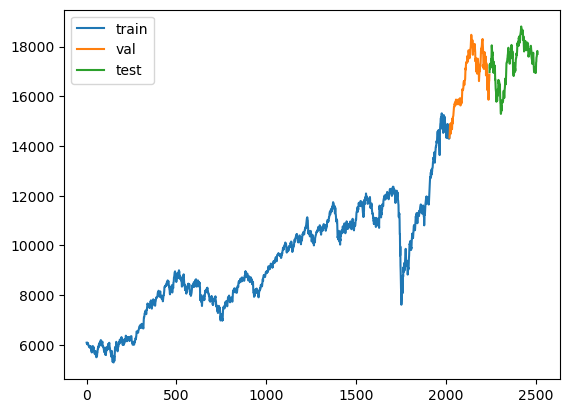

In [34]:
torch.manual_seed(args.seed)
dataloaders = load_data(df, **dataset_configs, **dataloader_configs)
train_loader, val_loader, test_loader = dataloaders

visualize_data(dataloaders, sample_idx=0)


In [73]:
# We've got 4 main components to specify: 
# 1. The embedding / input projection (e.g., an MLP)
# 2. The encoder block ("open-loop" / convolutional SpaceTime SSMs go here)
# 3. The decoder block ("closed-loop" / recurrent SpaceTime SSMs go here)
# 4. The output projection (e.g., an MLP)

config_dir = 'spacetime/configs/'

embedding_config = """
method: repeat
kwargs:
  input_dim: 1
  embedding_dim: null
  n_heads: 4
  n_kernels: 32
"""
embedding_config = OmegaConf.create(embedding_config)

encoder_config = """
blocks:
- input_dim: 128
  pre_config: 'ssm/preprocess/residual'
  ssm_config: 'ssm/companion_preprocess'
  mlp_config: 'mlp/default'
  skip_connection: true
  skip_preprocess: false
"""
encoder_config = OmegaConf.create(encoder_config)

decoder_config = """
blocks:
- input_dim: 128
  pre_config: 'ssm/preprocess/none'
  ssm_config: 'ssm/closed_loop/companion'
  mlp_config: 'mlp/identity'
  skip_connection: false
  skip_preprocess: false
"""
decoder_config = OmegaConf.create(decoder_config)

output_config = """
input_dim: 128
output_dim: 1
method: mlp
kwargs:
  input_dim: 128
  output_dim: 1
  activation: gelu
  dropout: 0.2
  layernorm: false
  n_layers: 1
  n_activations: 1
  pre_activation: true
  input_shape: bld
  skip_connection: false
  average_pool: null
"""
output_config = OmegaConf.create(output_config)

In [74]:
from model.network import SpaceTime
from setup import seed_everything

In [75]:
# Initialize SpaceTime encoder and decoder preprocessing, SSM, and MLP components
# - These are referenced as paths in the above encoder and decoder configs
def init_encoder_decoder_config(config, config_dir):
    for ix, _config in enumerate(config['blocks']):
        # Load preprocess kernel configs
        c_path = join(config_dir, f"{_config['pre_config']}.yaml")
        _config['pre_config'] = OmegaConf.load(c_path)
        # Load SSM kernel configs
        c_path = join(config_dir, f"{_config['ssm_config']}.yaml")
        _config['ssm_config'] = OmegaConf.load(c_path)
        # Load MLP configs
        c_path = join(config_dir, f"{_config['mlp_config']}.yaml")
        _config['mlp_config'] = OmegaConf.load(c_path)
    return config

In [76]:
encoder_config = init_encoder_decoder_config(encoder_config, join(config_dir, 'model'))
decoder_config = init_encoder_decoder_config(decoder_config, join(config_dir, 'model'))

In [77]:
# Initialize SpaceTime model
model_configs = {
    'embedding_config': embedding_config,
    'encoder_config': encoder_config,
    'decoder_config': decoder_config,
    'output_config': output_config,
    'lag': dataset_configs.lag,
    'horizon': dataset_configs.horizon
}
seed_everything(args.seed)

model = SpaceTime(**model_configs)

In [78]:
model

SpaceTime(
  (embedding): RepeatEmbedding()
  (encoder): Encoder(
    (blocks): Sequential(
      (0): Block(
        (pre): ResidualSSM()
        (ssm): CompanionSSM()
        (mlp): MLP(
          (layernorm): Identity()
          (layers): Sequential(
            (0): GELU(approximate='none')
            (1): Dropout(p=0.2, inplace=False)
            (2): Linear(in_features=128, out_features=128, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (blocks): ClosedLoopBlock(
      (pre): Identity()
      (ssm): ClosedLoopCompanionSSM()
      (mlp): Identity()
    )
  )
  (output): MLP(
    (layernorm): Identity()
    (layers): Sequential(
      (0): GELU(approximate='none')
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [79]:
from loss import get_loss
from data_transforms import get_data_transforms
from optimizer import get_optimizer, get_scheduler
from setup.configs.optimizer import get_optimizer_config, get_scheduler_config

from train import train_model, evaluate_model, plot_forecasts

In [87]:
arg_config = f"""
lag: {dataset_configs.lag}
horizon: {dataset_configs.horizon}
features: S
lr: 3e-6
weight_decay: 1e-4
dropout: 0.1
criterion_weights:
- 10
- 1
- 10
optimizer: adam
scheduler: timm_cosine
max_epochs: 500
early_stopping_epochs: 20
data_transform: mean
loss: informer_rmse
val_metric: informer_rmse
seed: 42
dataset: nse
variant: null
model: SpaceTime
"""
class Args():
    def __init__(self, args):
        for k, v in args.items():
            setattr(self, k, v)
            
args = Args(OmegaConf.create(arg_config))
# GPU
args.device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

# These others are not super important
args.checkpoint_dir = './checkpoints'
args.log_dir = './log_dir'
args.variant = None
args.no_wandb = True
args.dataset_type = 'informer'  # for standard forecasting
args.log_epoch = 1000

In [81]:
seed_everything(args.seed)
model = SpaceTime(**model_configs)  # Reset model from here

model.set_lag(args.lag)
model.set_horizon(args.horizon)
    
# Initialize optimizer and scheduler
optimizer = get_optimizer(model, get_optimizer_config(args, config_dir))
scheduler = get_scheduler(model, optimizer, get_scheduler_config(args, config_dir))
    
# Loss objectives
criterions = {name: get_loss(name) for name in ['rmse', 'mse', 'mae']}
eval_criterions = criterions
for name in ['rmse', 'mse', 'mae']:
    eval_criterions[f'informer_{name}'] = get_loss(f'informer_{name}')
    
# Data transforms, e.g., normalization
input_transform, output_transform = get_data_transforms(args.data_transform, args.lag)

In [90]:
optimizer = get_optimizer(model, get_optimizer_config(args, config_dir))
scheduler = get_scheduler(model, optimizer, get_scheduler_config(args, config_dir))


In [83]:
from setup import initialize_experiment

In [84]:
initialize_experiment(args, experiment_name_id='',
                      best_train_metric=1e10, 
                      best_val_metric=1e10)

In [91]:
initialize_experiment(args, experiment_name_id='',
                      best_train_metric=1e10, 
                      best_val_metric=1e10)

-> Created model checkpoint saving directory at ./checkpoints/nse/nse!
-> Created logging directory at ./log_dir/spacetime-d=nse-f=S-horizon=2/spacetime-d=nse-f=S-horizon=2!


In [85]:
splits = ['train', 'val', 'test']
dataloaders_by_split = {split: dataloaders[ix] 
                        for ix, split in enumerate(splits)}

In [46]:
# Actually train model


model = train_model(model, optimizer, scheduler, dataloaders_by_split, 
                    criterions, max_epochs=args.max_epochs, config=args, 
                    input_transform=input_transform,
                    output_transform=output_transform,
                    val_metric=args.val_metric, wandb=None, 
                    return_best=True, early_stopping_epochs=args.early_stopping_epochs) 

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping at epoch 118...
-> Saved best val model checkpoint at epoch 98!
   - Saved to: ./checkpoints/sp500/bval-m=SpaceTime-la=50-ho=2-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
-> Saved best train model checkpoint at epoch 115!
   - Saved to: ./checkpoints/sp500/btrn-m=SpaceTime-la=50-ho=2-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
Returning best val model from epoch 98


In [93]:
model = train_model(model, optimizer, scheduler, dataloaders_by_split, 
                    criterions, max_epochs=args.max_epochs, config=args, 
                    input_transform=input_transform,
                    output_transform=output_transform,
                    val_metric=args.val_metric, wandb=None, 
                    return_best=True) 

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping at epoch 101...
-> Saved best val model checkpoint at epoch 1!
   - Saved to: ./checkpoints/nse/nse/bval-m=SpaceTime-la=50-ho=2-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.1-lr=3e-06-op=adam-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
-> Saved best train model checkpoint at epoch 3!
   - Saved to: ./checkpoints/nse/nse/btrn-m=SpaceTime-la=50-ho=2-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.1-lr=3e-06-op=adam-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
Returning best val model from epoch 1


In [71]:
# import imp
# epoch_module = imp.load_source('epoch_module', '/kaggle/working/spacetime/train/epoch.py')
# sys.modules['.epoch'] = epoch_module

In [77]:
# train_module = imp.load_source('train_module', '/kaggle/working/spacetime/train/evaluate.py')
# sys.modules['train.evaluate'] = train_module

ImportError: attempted relative import with no known parent package

In [73]:
from dataloaders import get_evaluation_loaders
from train.evaluate import plot_forecasts

-----------------------------------------
Best validation model: eval_train metrics
-----------------------------------------
- total: 4040.0
- rmse: 39.42184507162264
- mse: 9306.065300123762
- mae: 72.97825649752475
- informer_rmse: 90.75121611356735
- informer_mse: 9308.403900146484
- informer_mae: 73.10820627212524
----------------------------------
Best validation model: val metrics
----------------------------------
- total: 446.0
- rmse: 123.56728701741172
- mse: 93765.16451793721
- mae: 226.63495174117153
- informer_rmse: 288.7187042236328
- informer_mse: 94015.44280133929
- informer_mae: 226.99713352748327
-----------------------------------
Best validation model: test metrics
-----------------------------------
- total: 536.0
- rmse: 99.43140650507229
- mse: 56727.95125932836
- mae: 184.22056830107277
- informer_rmse: 222.3432905409071
- informer_mse: 53589.5283203125
- informer_mae: 177.59812757703992


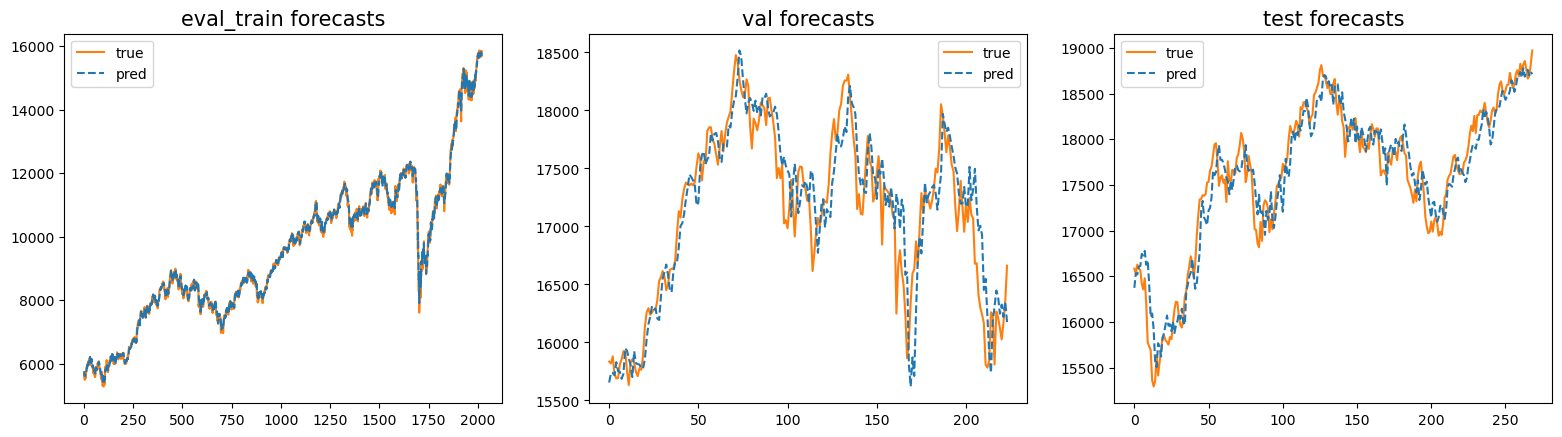

In [74]:
eval_splits = ['eval_train', 'val', 'test']
eval_loaders = get_evaluation_loaders(dataloaders, batch_size=dataloader_configs.batch_size)
eval_loaders_by_split = {split: eval_loaders[ix] for ix, split in
                         enumerate(eval_splits)}
model, log_metrics, total_y = evaluate_model(model, dataloaders=eval_loaders_by_split, 
                                             optimizer=optimizer, scheduler=scheduler, 
                                             criterions=eval_criterions, config=args,
                                             epoch=args.best_val_metric_epoch, 
                                             input_transform=input_transform, 
                                             output_transform=output_transform,
                                             val_metric=args.val_metric, wandb=None,
                                             train=False)
n_plots = len(splits) # train, val, test
fig, axes = plt.subplots(1, n_plots, figsize=(6.4 * n_plots, 4.8))

plot_forecasts(total_y, splits=eval_splits, axes=axes)

In [107]:
def predict_func(df):
    with torch.no_grad():
        df = df["Close"]
        inp = torch.reshape(torch.tensor(df.to_numpy()).unsqueeze(-1).float(), (1, 50, 1))
    return model( inp )

In [105]:
print(len(samples))
samples[0].shape

2512


(52,)

In [97]:
def evaluate():
    # Input the csv file
    """
    Sample evaluation function
    Don't modify this function
    """
    df = pd.read_csv('/kaggle/input/stock-index/sample_input.csv')
     
    actual_close = np.loadtxt('/kaggle/input/stock-index/sample_close.txt')
    
    pred_close = predict_func(df)
    
    # Calculation of squared_error
    actual_close = np.array(actual_close)
    pred_close = np.array(pred_close)
    mean_square_error = np.mean(np.square(actual_close-pred_close))


    pred_prev = [df['Close'].iloc[-1]]
    pred_prev.append(pred_close[0])
    pred_curr = pred_close
    
    actual_prev = [df['Close'].iloc[-1]]
    actual_prev.append(actual_close[0])
    actual_curr = actual_close

    # Calculation of directional_accuracy
    pred_dir = np.array(pred_curr)-np.array(pred_prev)
    actual_dir = np.array(actual_curr)-np.array(actual_prev)
    dir_accuracy = np.mean((pred_dir*actual_dir)>0)*100

    print(f'Mean Square Error: {mean_square_error:.6f}\nDirectional Accuracy: {dir_accuracy:.1f}')
    


In [98]:
evaluate()

/tmp/ipykernel_28/1718408289.py:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  pred_close = np.array(pred_close)


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [118]:
device = torch.device('cuda')

In [119]:
tempdf = pd.read_csv('/kaggle/input/stock-index/sample_input.csv')
x = predict_func(tempdf).to()

In [122]:
x.shape

torch.Size([1, 50, 1])

In [131]:
model.eval()

SpaceTime(
  (embedding): RepeatEmbedding()
  (encoder): Encoder(
    (blocks): Sequential(
      (0): Block(
        (pre): ResidualSSM()
        (ssm): CompanionSSM()
        (mlp): MLP(
          (layernorm): Identity()
          (layers): Sequential(
            (0): GELU(approximate='none')
            (1): Dropout(p=0.2, inplace=False)
            (2): Linear(in_features=128, out_features=128, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (blocks): ClosedLoopBlock(
      (pre): Identity()
      (ssm): ClosedLoopCompanionSSM()
      (mlp): Identity()
    )
  )
  (output): MLP(
    (layernorm): Identity()
    (layers): Sequential(
      (0): GELU(approximate='none')
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [127]:
def forecast( 
                 x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform model inference on lag terms. 
        - See spacetime/train/step/informer.py for more details.
        
        Inputs:
        - x: lag terms of shape (1, lag, 1) (batch, len, dim)
        
        Returns:
        - Tuple of (current price, forecasted price)
        """
        with torch.no_grad():
            try:
                model.to(device)
            except:
                pass
            u = input_transform(x)
            u = u.to(args.device)

            y, z = model(u)
            return y, z
#             y = output_transform(y[0]).cpu()
#             z = output_transform(z[0]).cpu()
            
#             y_curr = x[0, -1:, 0].item()
#             y_pred = y[0, -1:, 0].item()
#             return y_curr, y_pred

In [123]:
tempdf.shape

(50, 7)

# Statistical Methods

In [101]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [147]:
# hyperparameters: lag, 



In [99]:
def create_ft_mtx(df, lag, close_only=False , drop_volume = False, flatten = False):
    (df := df.drop(["Date"], axis = 1)) if "Date" in df.columns else print("No date column")
    (df := df.drop(["Adj Close"], axis = 1)) if "Adj Close" in df.columns else print("No adj close column")
    
    if close_only:
        df = df["Close"]
    
    if drop_volume:
        (df :=df.drop(["Volume"], axis = 1)) if "Volume" in df.columns else print("No adj close column")
    
    scaler = StandardScaler()
    df1 = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

    rolling_windows = [window for window in df1.rolling(lag + 2) if len(window.values) == lag + 2]
    rolling_dfs = [pd.DataFrame(window.values, columns=df1.columns) for window in rolling_windows]
    
    if not flatten:
        X = [ i[0:lag].to_numpy() for i in rolling_dfs]
    else:
        X = [ i[0:lag].to_numpy().flatten() for i in rolling_dfs]
        
    y = [ i["Close"].iloc[lag:lag+2].to_numpy() for i in rolling_dfs]
    
    return X, y

In [100]:
def create_train_test_data(lag, ratio =0.85, close_only=False , drop_volume = False, flatten = False):
    X, y = create_ft_mtx(nse_data, lag)
    X2, y2 = create_ft_mtx(bse_data, lag)

    X = np.concatenate((X, X2), axis = 0)
    y = np.concatenate((y, y2), axis = 0)

    idx = int(ratio * len(X))

    X_train = np.array(X[0:idx])
    X_test = np.array(X[idx:])
    y_train = np.array(y[0:idx])
    y_test = np.array(y[idx:])
    
    return X_train, y_train, X_test, y_test

In [102]:
def train_regressor(model, X_train, y_train):
    
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train) 
    print("Train R^2")
    print(score)
    preds = model.predict(X_train)
    print("MSE")
    mse = mean_squared_error(preds, y_train)
    print(mse)
    print("MAE")
    mae = mean_absolute_error(preds, y_train)
    print(mae)
    

In [103]:
def evaluate_regressor(model, X_test, y_test):
    score = model.score(X_test, y_test) 
    print("Train R^2")
    print(score)
    preds = model.predict(X_test)
    print("MSE")
    mse = mean_squared_error(preds, y_test)
    print(mse)
    print("MAE")
    mae = mean_absolute_error(preds, y_test)
    print(mae)
    

In [ ]:
def plot_preds(model, X_test, y_test):
    

In [57]:
X, y = create_ft_mtx(nse_data, 15, True, flatten = True)
X2, y2 = create_ft_mtx(bse_data, 15, True, flatten = True)

X = np.concatenate((X, X2), axis = 0)
y = np.concatenate((y, y2), axis = 0)

idx = int(0.85 * len(X))

X_train = np.array(X[0:idx])
X_test = np.array(X[idx:])
y_train = np.array(y[0:idx])
y_test = np.array(y[idx:])

No date column
No date column


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

In [58]:
X_train.shape

(6227, 60)

5285.0

In [45]:
def train_regressor(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    fac = (mx -mn)
    disp = (y_test- preds)[0:10] * fac
    print(disp)
    mse = mean_squared_error(y_test, preds ) 
    mse = mse *  fac ** 2
    print(mse)

In [51]:
models = {
#     "cat": CatBoostRegressor(loss_function= 'MultiRMSE', eval_metric= 'MultiRMSE', verbose = False),
    "ridge": Ridge(),
    "lin": LinearRegression(),
#     "xgb": XGBRegressor()
}


In [59]:
%%time
for i in models:
    print(i)
    train_regressor(models[i],  X_train, y_train, X_test, y_test)
    

ridge
[[ 79.57450954  50.10454393]
 [ 19.2531099   -7.04890344]
 [-20.28668993 -59.67985314]
 [-44.85879617  60.45874326]
 [ 86.25342641  83.54773947]
 [ 57.3763546   66.87875541]
 [ 32.5977226   31.01604749]
 [ 21.89854852  61.58877666]
 [ 57.46295927  22.57474676]
 [  0.23188306 -79.24922707]]
27727.21048968362
lin
[[ 40.86617912   8.580018  ]
 [-30.32389259 -53.34808379]
 [-22.85000947 -65.22225582]
 [-39.71374207  82.44978992]
 [123.79850291 113.175825  ]
 [-14.18645346  11.22277022]
 [ 25.36050372  18.35777749]
 [ -7.17062985  29.01230072]
 [ 38.37126553  12.53759833]
 [-26.88969715 -86.30869983]]
21446.481033176035
CPU times: user 44.3 ms, sys: 9.99 ms, total: 54.3 ms
Wall time: 47.3 ms


In [18]:
X_train.shape

(6210, 125)

In [19]:
X_test.shape

(1097, 125)

# LSTMs
Bismillah

In [178]:
import tensorflow as tf

# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.G(128, activation= 'relu', input_shape=(25, 5), dropout=0.2, return_sequences = True),
     tf.keras.layers.LSTM(128,activation= 'relu', dropout=0.2),
#     tf.keras.layers.Dense(2),
    tf.keras.layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 25, 128)           68608     
                                                                 
 lstm_35 (LSTM)              (None, 128)               131584    
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                                 
Total params: 200,450
Trainable params: 200,450
Non-trainable params: 0
_________________________________________________________________


In [179]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
98/98 [==============================] - 14s 109ms/step - loss: 0.0078
Epoch 2/100
98/98 [==============================] - 10s 102ms/step - loss: 6.0354e-04
Epoch 3/100
98/98 [==============================] - 10s 105ms/step - loss: 4.8397e-04
Epoch 4/100
98/98 [==============================] - 11s 108ms/step - loss: 4.8130e-04
Epoch 5/100
98/98 [==============================] - 10s 101ms/step - loss: 4.6411e-04
Epoch 6/100
98/98 [==============================] - 10s 100ms/step - loss: 3.7304e-04
Epoch 7/100
98/98 [==============================] - 10s 105ms/step - loss: 3.6006e-04
Epoch 8/100
98/98 [==============================] - 10s 103ms/step - loss: 3.5487e-04
Epoch 9/100
98/98 [==============================] - 10s 99ms/step - loss: 3.1326e-04
Epoch 10/100
98/98 [==============================] - 10s 99ms/step - loss: 5.0420e-04
Epoch 11/100
98/98 [==============================] - 11s 111ms/step - loss: 3.6082e-04
Epoch 12/100
98/98 [===========================

In [233]:
history = model.fit(X_train, y_train, epochs=100, batch_size= 128)

Epoch 1/100
49/49 [==============================] - 5s 100ms/step - loss: 1.5570e-04
Epoch 2/100
49/49 [==============================] - 5s 100ms/step - loss: 9.4370e-05
Epoch 3/100
49/49 [==============================] - 5s 101ms/step - loss: 8.9473e-05
Epoch 4/100
49/49 [==============================] - 5s 100ms/step - loss: 8.8130e-05
Epoch 5/100
49/49 [==============================] - 5s 103ms/step - loss: 8.2020e-05
Epoch 6/100
49/49 [==============================] - 5s 98ms/step - loss: 9.2964e-05
Epoch 7/100
49/49 [==============================] - 6s 119ms/step - loss: 7.9799e-05
Epoch 8/100
49/49 [==============================] - 5s 100ms/step - loss: 8.1414e-05
Epoch 9/100
49/49 [==============================] - 5s 104ms/step - loss: 8.7181e-05
Epoch 10/100
49/49 [==============================] - 5s 104ms/step - loss: 8.0541e-05
Epoch 11/100
49/49 [==============================] - 5s 101ms/step - loss: 8.5341e-05
Epoch 12/100
49/49 [==============================] -

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
# accuracy = model.history.history['accuracy']

# Plot the metrics
plt.plot(loss, label='Loss')
# plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [194]:
scaler.inverse_transform(preds)

Exception ignored in: <function _xla_gc_callback at 0x793b66e24c10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


ValueError: operands could not be broadcast together with shapes (1097,2) (6,) (1097,2) 

In [193]:
preds = model.predict(X_test)

35/35 [==============================] - 1s 8ms/step


In [208]:
scaler

MinMaxScaler()

In [211]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,130900
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,129000
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,137000
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,185200
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,147600


In [28]:
mx = max(nse_data["Close"]) 
mn = min(nse_data["Close"]) 

# scd= preds * (mx -mn) + mn

In [225]:
np.mean((preds-y_test)^2)

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [229]:
(preds-y_test)

array([[-0.11507002, -0.12248266],
       [-0.12611959, -0.12576599],
       [-0.12036864, -0.1210895 ],
       ...,
       [-0.22820902, -0.22518544],
       [-0.23143683, -0.23608346],
       [-0.23954881, -0.24514055]])

In [226]:
preds.shape

(1097, 2)

In [227]:
y_test.shape

(1097, 2)

In [219]:
scd

array([[10932.155, 10937.773],
       [10887.994, 10893.516],
       [10967.39 , 10969.686],
       ...,
       [15632.93 , 15672.155],
       [15586.592, 15625.751],
       [15578.32 , 15616.837]], dtype=float32)

In [222]:
y_test* (mx -mn) + mn

array([[12507.13031209, 12614.20519589],
       [12614.20519589, 12614.88734482],
       [12614.88734482, 12627.04903433],
       ...,
       [18756.4496541 , 18754.29071573],
       [18754.29071573, 18857.04862272],
       [18857.04862272, 18972.09960938]])

In [196]:
preds

array([[0.41258964, 0.41300005],
       [0.40936312, 0.40976655],
       [0.4151639 , 0.4153316 ],
       ...,
       [0.75603527, 0.7589011 ],
       [0.7526497 , 0.75551075],
       [0.7520454 , 0.75485945]], dtype=float32)

In [13]:
len(df)

2563

In [123]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,130900
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,129000
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,137000
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,185200
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,147600


In [189]:
loss = history['loss']
plt.plot(loss, label='Loss')
# plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

In [249]:
# import tensorflow as tf

# Define the LSTM model
model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(16, activation= 'relu', input_shape=(50, 5), dropout=0.3, return_sequences = True),
     tf.keras.layers.LSTM(32,activation= 'relu', dropout=0.2),
#     tf.keras.layers.Dense(2),
    tf.keras.layers.Dense(2)
])

# Compile the model
model2.compile(optimizer='adam', loss='mse')

# Print the model summary
model2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 50, 16)            1408      
                                                                 
 lstm_41 (LSTM)              (None, 32)                6272      
                                                                 
 dense_26 (Dense)            (None, 2)                 66        
                                                                 
Total params: 7,746
Trainable params: 7,746
Non-trainable params: 0
_________________________________________________________________


In [235]:
X1, y1 = create_ft_mtx(nse_data, 50)
X2, y2 = create_ft_mtx(bse_data, 50)

X3 = np.concatenate((X1, X2), axis = 0)
y3 = np.concatenate((y1, y2), axis = 0)

idx = int(0.85 * len(X))

X_train2 = np.array(X3[0:idx])
X_test2 = np.array(X3[idx:])
y_train2 = np.array(y3[0:idx])
y_test2 = np.array(y3[idx:])

No date column
No adj close column
No date column
No adj close column


In [250]:
X_train2.shape

(6210, 50, 5)

In [ ]:
model2.fit(X_train2, y_train2, epochs=100, batch_size=512)

In [254]:
model2.fit(X_train2, y_train2, epochs=100, batch_size=128)

Epoch 1/100
49/49 [==============================] - 9s 189ms/step - loss: 4.7941e-04
Epoch 2/100
49/49 [==============================] - 10s 206ms/step - loss: 4.6019e-04
Epoch 3/100
49/49 [==============================] - 9s 187ms/step - loss: 4.2554e-04
Epoch 4/100
49/49 [==============================] - 9s 184ms/step - loss: 4.2218e-04
Epoch 5/100
49/49 [==============================] - 10s 202ms/step - loss: 4.6142e-04
Epoch 6/100
49/49 [==============================] - 9s 191ms/step - loss: 4.1838e-04
Epoch 7/100
49/49 [==============================] - 9s 186ms/step - loss: 4.4300e-04
Epoch 8/100
49/49 [==============================] - 9s 190ms/step - loss: 4.5104e-04
Epoch 9/100
49/49 [==============================] - 10s 208ms/step - loss: 4.2652e-04
Epoch 10/100
49/49 [==============================] - 9s 187ms/step - loss: 4.0844e-04
Epoch 11/100
49/49 [==============================] - 10s 195ms/step - loss: 4.2514e-04
Epoch 12/100
49/49 [============================

KeyboardInterrupt: 

In [261]:
model2.predict(X_test2) * (mx - mn)  - y_test2 * (mx - mn)

33/33 [==============================] - 1s 15ms/step


-3539.0213206377284

In [247]:
y_test * (mx - mn) + mn

array([[12507.13031209, 12614.20519589],
       [12614.20519589, 12614.88734482],
       [12614.88734482, 12627.04903433],
       ...,
       [18756.4496541 , 18754.29071573],
       [18754.29071573, 18857.04862272],
       [18857.04862272, 18972.09960938]])